In [ ]:
#| default_exp dtcam

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from IPython.display import Image
from llmcam.gpt4v import ask_gpt4v
from llmcam.yolo import detect_objects
from llmcam.fn_to_fc import *
import json
import torch

In [ ]:
#| export
import requests
from pathlib import Path
from PIL import Image
from io import BytesIO
from datetime import datetime
import os

In [ ]:
#| export
stations_url = "https://tie.digitraffic.fi/api/weathercam/v1/stations"

## build an addressbook of camera installed address, and image capture url
```
[
    {
        "address": <camera installed location>,
        "url": <capture image url>,
    },
    {
        "address": <camera installed location>,
        "url": <capture image url>,
    },
    ....
]
```

In [ ]:
def build_address_book(stations_url:str):
    table = []
    stations = requests.get(stations_url).json()['features']
    for station in stations:
        station = requests.get(stations_url+'/'+station['id']).json().get('properties')
        if not station:
            continue
        for preset in station['presets']:
            try:
                addr = ",".join([preset['presentationName'], station['names'].get('fi'), station['municipality'], station['province']])
            except:
                continue
            info = {
                #"id": preset['id'],
                "address": addr,
                "url": preset['imageUrl'],
            }
            table.append(info)
    return table

In [ ]:
def address_book(stations_url:str=stations_url):
    """get an address book [{"address":<camera installed address>, "url":<image capture url>}]"""
    if os.path.exists("preset_image_url.json"):
        with open("preset_image_url.json", "r") as f:
            return json.load(f)

    data = build_address_book(stations_url)
    with open("preset_image_url.json", "w") as f:
        json.dump(data, f, indent=4) 
    return data

In [ ]:
#| export
def get_address_book(stations_url:str=stations_url):
    """get an address book of <camera location>:<image url>"""   
    data = address_book(stations_url)
    return json.dumps(data)

In [ ]:
from llmcam.downloader import *

In [ ]:
#| eval: false
tools = [tool_schema(f) for f in [get_address_book, download_file]]
msgs = form_msgs([
    ("system", "You are a helpful system administrator. Use the supplied tools to assist the user."),
    ("user", "get an address book and pick up the location including Espoo"),
])
complete(msgs, tools=[tool_schema(get_address_book)])
msgs.append(form_msg("user", "there should be more?"))
msgs.append(form_msg("user", "download captured image of them"))
msgs.append(form_msg("user", "How many cars are seen?"))
complete(msgs, tools=tools)

## Simple capture function

In [ ]:
#| export
def stations(key:str)->list[dict]:
    "Get all weather station including `key` word"
    res = requests.get(stations_url)
    assert res.status_code == 200
    stations = res.json()['features']
    return [st for st in stations if key.lower() in st['properties']['name'].lower()]

In [ ]:
Porvoos = stations("Porvoo")
assert "porvoo" in Porvoos[0]['properties']['name'].lower()

In [ ]:
#| export
def presets(station:dict)->list[dict]:
    "Get all presets at a given weather station"
    res = requests.get(stations_url + "/" + station['id'])
    assert res.status_code == 200
    presets = res.json()['properties']['presets']
    return presets

In [ ]:
preset = presets(Porvoos[0])[0]
imageUrl = preset['imageUrl']
print(imageUrl)
assert "jpg" in imageUrl

https://weathercam.digitraffic.fi/C0150200.jpg


In [ ]:
#| export
def capture(preset:dict)->Path:
    "Capture image at a given preset location in a Weather station, and return an image path"
    req = requests.get(preset['imageUrl'], headers={'Digitraffic-User': 'NinjaLABO/LLMCAM 1.0'})
    assert req.status_code == 200
    img = Image.open(BytesIO(req.content))
    #img.show()
    dt = datetime.strptime(req.headers["last-modified"], '%a, %d %b %Y %H:%M:%S %Z')
    dtstr = dt.strftime("%Y.%m.%d_%H:%M:%S")
    path = f"../data/cap_{dtstr}_{preset['presentationName']}_{preset['id']}.jpg"
    img.save(path, format="JPEG")
    return req.headers, path

In [ ]:
preset

{'id': 'C0150200',
 'presentationName': 'Porvoo',
 'inCollection': True,
 'resolution': '704x576',
 'directionCode': '0',
 'imageUrl': 'https://weathercam.digitraffic.fi/C0150200.jpg',
 'direction': 'UNKNOWN'}

In [ ]:
hdr, path = capture(preset)
hdr

{'Content-Type': 'image/jpeg', 'Content-Length': '95634', 'Connection': 'keep-alive', 'x-amz-id-2': 'qJyGA+19ielw624EZ3gWJpEo9HSXUyogx94j4NtzC3VRAyYx6Fn4KboROpbRBB4P8dRIhJyiaNk=', 'x-amz-request-id': 'YRGGZ08WY6YRR0V5', 'last-modified': 'Thu, 21 Nov 2024 13:51:57 GMT', 'x-amz-expiration': 'expiry-date="Sat, 23 Nov 2024 00:00:00 GMT", rule-id="Delete versions and current images after 24h"', 'x-amz-server-side-encryption': 'AES256', 'X-Amz-Meta-Last-Modified': 'Thu, 21 Nov 2024 13:51:57 GMT', 'x-amz-version-id': 'ssEa88R_MSaHPPnzwhq0hcC0DXLZ4tTt', 'Accept-Ranges': 'bytes', 'Server': 'AmazonS3', 'Date': 'Thu, 21 Nov 2024 13:57:59 GMT', 'ETag': '"0d26e22361830e3bcf1a66a956d4bf18"', 'Vary': 'Accept-Encoding', 'X-Cache': 'Hit from cloudfront', 'Via': '1.1 6666f57b09bbb5ce206afb05563f731e.cloudfront.net (CloudFront)', 'X-Amz-Cf-Pop': 'HAM50-P2', 'Alt-Svc': 'h3=":443"; ma=86400', 'X-Amz-Cf-Id': '-m290lJAEmHoRhbJm7TQ4KVaZYle9kxwi1BgtTzbrqNjgwU-kPve8g==', 'Age': '94'}

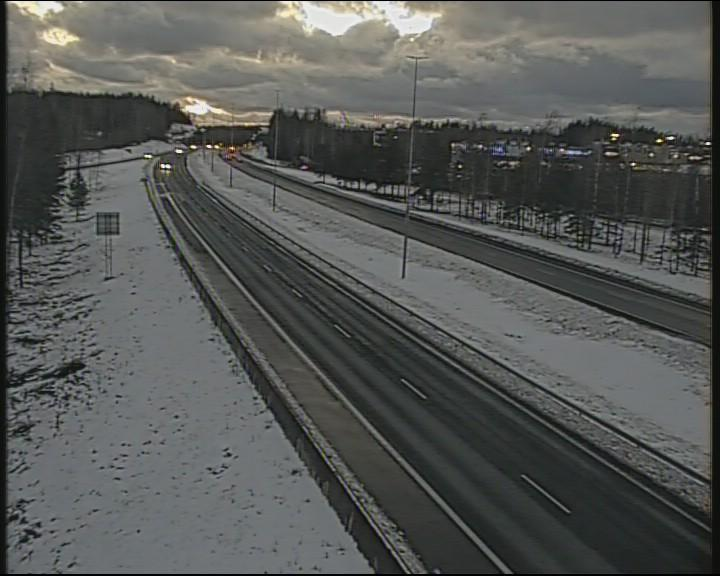

In [ ]:
display(Image.open(path))

In [ ]:
#| export
def cap(
    key:str = "Porvoo", # location keyword
)->str:
    "Capture an image at specified location, save it, and return its path"
    _, path = capture(presets(stations(key)[0])[0])
    return str(path)

In [ ]:
show_doc(cap)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/dtcam.py#L46){target="_blank" style="float:right; font-size:smaller"}

### cap

>      cap (key:str='Porvoo')

*Capture an image at specified location, save it, and return its path*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| key | str | Porvoo | location keyword |
| **Returns** | **str** |  |  |

In [ ]:
#| eval: false
path = cap("porvoo")
print(path)
ask_gpt4v(path)

../data/cap_2024.11.21_13:51:57_Porvoo_C0150200.jpg


{'timestamp': None,
 'location': None,
 'dimensions': '720 x 576',
 'building': 0,
 'buildings_height_range': None,
 'car': 3,
 'truck': 0,
 'boat': 0,
 'available_parking_space': None,
 'street_lights': 10,
 'person': 0,
 'time_of_day': None,
 'artificial_lighting': None,
 'visibility_clear': True,
 'sky_visible': True,
 'sky_light_conditions': None,
 'waterbodies_visible': False,
 'waterbodies_type': None}

In [ ]:
#| eval: false
detect_objects(cap('porvoo'))

Using cache found in /home/doyu/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-12 Python-3.12.4 torch-2.4.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/home/doyu/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


'{}'

In [ ]:
#| eval: false
def __ask_gpt4v(
    path: str # file path to analyze
)->str:
    "ask gpt4v to analyze an image given"
    return json.dumps(ask_gpt4v(path))

In [ ]:
#| eval: false
show_doc(__ask_gpt4v)

---

### __ask_gpt4v

>      __ask_gpt4v (path:str)

*ask gpt4v to analyze an image given*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| path | str | file path to analyze |
| **Returns** | **str** |  |

In [ ]:
#| eval: false
tools = [tool_schema(f) for f in [cap, detect_objects, __ask_gpt4v] ]
tools

[{'type': 'function',
  'function': {'name': 'cap',
   'description': 'Capture an image at specified location, save it, and return its path',
   'parameters': {'type': 'object',
    'properties': {'module': {'type': 'string',
      'description': 'The module where the function is located.',
      'default': '__main__'},
     'key': {'type': 'string', 'description': 'location keyword'}},
    'required': []}}},
 {'type': 'function',
  'function': {'name': 'detect_objects',
   'description': 'Run YOLO object detection on an input image.',
   'parameters': {'type': 'object',
    'properties': {'module': {'type': 'string',
      'description': 'The module where the function is located.',
      'default': 'llmcam.yolo'},
     'image_path': {'type': 'string', 'description': 'Path/URL of image'},
     'conf': {'type': 'number', 'description': 'Confidence threshold'}},
    'required': ['image_path']}}},
 {'type': 'function',
  'function': {'name': '__ask_gpt4v',
   'description': 'ask gpt4v to 

In [ ]:
def callback(name, tools=[], **kwargs): return globals().get(name)(**kwargs)

In [ ]:
#| eval: false
msgs = form_msgs([
    ("system", "You are a helpful system administrator. Use the supplied tools to assist the user."),
    ("user", "Capture an image in Porvoo and tell me the path"),
])
complete(msgs, tools=tools)

('assistant',
 'The image has been captured in Porvoo. The path to the image is `../data/cap_2024.11.21_13:51:57_Porvoo_C0150200.jpg`.')

In [ ]:
#| eval: false
msgs.append(form_msg("user", f"analyze this captured image"))
complete(msgs, tools=tools)

('assistant',
 'The captured image in Porvoo has the following characteristics:\n\n- **Dimensions:** 720 x 576\n- **Road Lanes:** 4\n- **Cars Visible:** 3\n- **Trucks Visible:** 0\n- **Available Parking Space:** 0\n- **Street Lights:** 6\n- **Time of Day:** Dusk\n- **Artificial Lighting:** Minimal\n- **Visibility:** Clear\n- **Sky Visible:** Yes\n- **Sky Light Conditions:** Cloudy\n- **Snow Coverage:** Partial\n- **Trees Visible:** Yes\n\nThis provides a detailed view of the image taken in Porvoo.')

In [ ]:
#| eval: false
msgs.append(form_msg("user", "Can you detect objects in the file?"))
complete(msgs, tools=tools)

Using cache found in /home/doyu/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-12 Python-3.12.4 torch-2.4.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/home/doyu/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


('assistant',
 'No objects were detected in the image with the specified confidence threshold of 0.5.')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()